# Time variation in correlations

|Duc Minh Nguyen        |             |    minh.nguyen4@student.uva.nl     |
|Tudor Ungureanu        |             |tudor.ungureanu@student.uva.nl         |


# Goal.
1. Use the theory explained in the book and the lecture notes to **select**, **estimate**, and **test** a multivariate GARCH model for daily log-returns (in percentages: $r_t = 100 \cdot \Delta \log P_t$) of the assigned stock and the Dow Jones index (ticker `^DJI`). Specifically, estimate both a **DCC model** and a **BEKK model**.
    * Each group will get their own stock/ticker. These have been randomly assigned. You can find the list on Canvas.
    * Keep in mind things such as *autocorrelations*, *volatility clustering*, and *distributional assumptions*.
    * **Motivate** your model choices using visual and statistical evidence.

2. Compare the DCC and BEKK model that you have estimated in the first question by using the second and third measures in Engle (2002), section 5, p. 343.
    1. The $F$ test described around equations (38) and (39).
    2. Out-of-sample evaluation of the one day ahead 99% VaR of an equally weighted portfolio of the single stock and the DJIA, described around equations (40) and (41).

#Data

In [ ]:
pip install arch

In [ ]:
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri

from rpy2.robjects.conversion import localconverter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

In [ ]:
tickers = ['INTC', 'DJI']
data = yf.download(tickers, start='1992-01-01', end='2019-01-01', auto_adjust=False)['Adj Close']


[*********************100%***********************]  2 of 2 completed


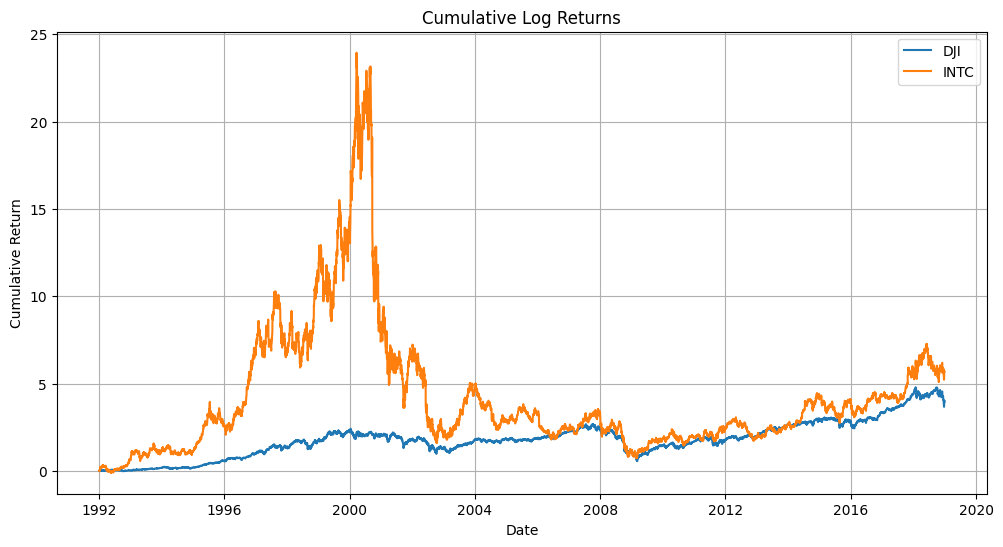

In [ ]:
# Calculate log returns
returns = np.log(data / data.shift(1)) * 100
returns.dropna(inplace=True)

# Calculate cumulative log returns
cumulative_returns = (1 + returns / 100).cumprod() - 1

# Plot cumulative log returns
plt.figure(figsize=(12, 6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Cumulative Log Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

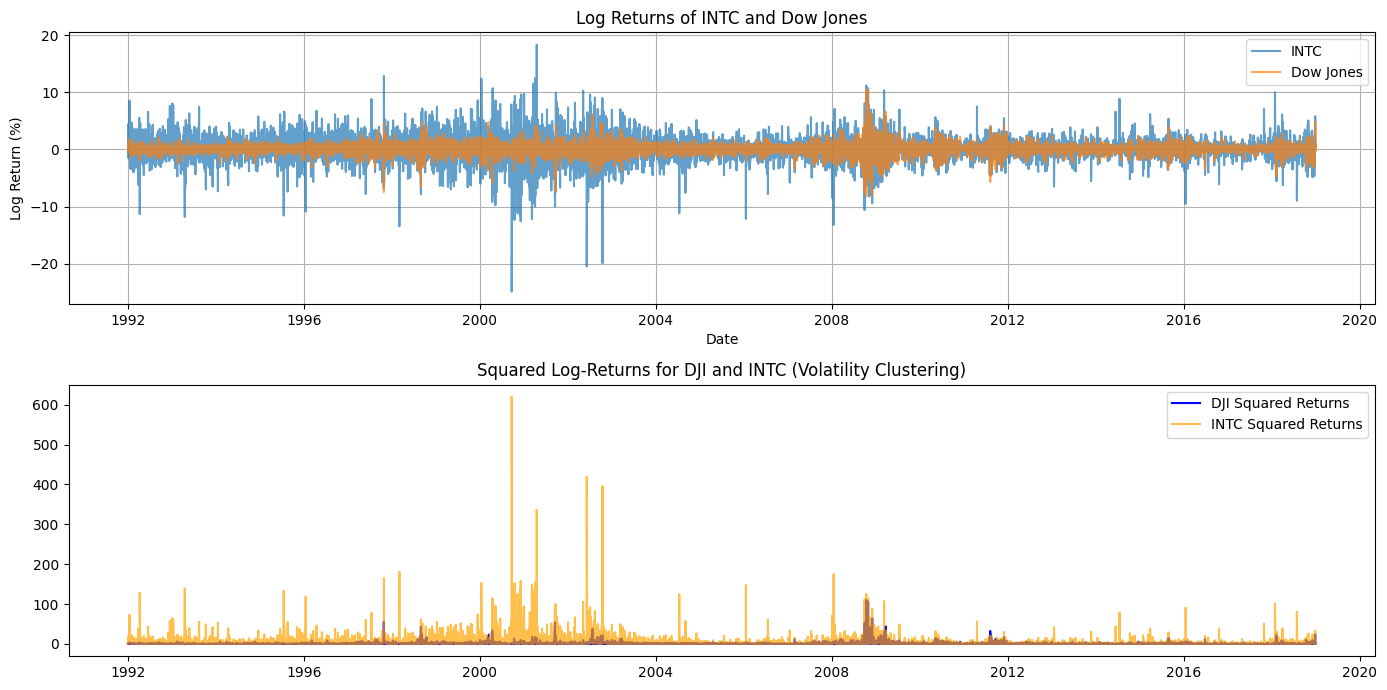

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
# Plot INTC log returns
plt.plot(returns.index, returns['INTC'], label='INTC', alpha=0.7)  # Adjust alpha for transparency

# Plot DJI log returns
plt.plot(returns.index, returns['DJI'], label='Dow Jones', alpha=0.7) # Adjust alpha for transparency

# Customize the plot for better visibility of differences
plt.title('Log Returns of INTC and Dow Jones')
plt.xlabel('Date')
plt.ylabel('Log Return (%)')
plt.legend()
plt.grid(True)

# Plot the squared returns
plt.subplot(2, 1, 2)
plt.plot(np.square(returns['DJI']), label='DJI Squared Returns', color='blue')
plt.plot(np.square(returns['INTC']), label='INTC Squared Returns', color='orange', alpha=0.7)
plt.title('Squared Log-Returns for DJI and INTC (Volatility Clustering)')
plt.legend()

plt.tight_layout()
plt.show()


plt.show()



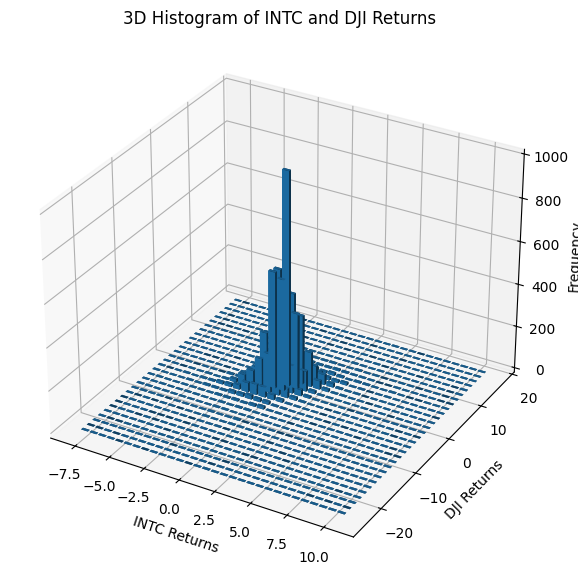

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(returns.iloc[:, 0], returns.iloc[:, 1], bins=30)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

dx = dy = 0.5

dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos,  dx, dy, dz, zsort='average')

ax.set_xlabel('INTC Returns')
ax.set_ylabel('DJI Returns')
ax.set_zlabel('Frequency')
ax.set_title('3D Histogram of INTC and DJI Returns')
plt.show()


In [ ]:
np.cov(returns[[ "INTC", "DJI"]].transpose())

array([[5.6336115 , 1.42294842],
       [1.42294842, 1.1343994 ]])

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

# Autocorrelation tests for returns (DJI and INTC)
ljungbox_dji = acorr_ljungbox(returns['DJI'], lags=10)
ljungbox_intc = acorr_ljungbox(returns['INTC'], lags=10)

#  Tests for squared returns (DJI and INTC)
ljungbox_dji_squared = acorr_ljungbox(np.square(returns['DJI']), lags=10)
ljungbox_intc_squared = acorr_ljungbox(np.square(returns['INTC']), lags=10)

# Print Ljung-Box Test results
print("Ljung-Box Test for DJI returns:", ljungbox_dji)
print("Ljung-Box Test for INTC returns:", ljungbox_intc)
print("Ljung-Box Test for DJI squared returns:",  ljungbox_dji_squared)
print("Ljung-Box Test for INTC squared returns:", ljungbox_intc_squared)

# ARCH effect test (checking if there is heteroscedasticity)
arch_dji = het_arch(returns['DJI'])
arch_intc = het_arch(returns['INTC'])

print("\nARCH Test for DJI:", arch_dji)
print("ARCH Test for INTC:", arch_intc)

# Fit an ARCH model to further inspect heteroscedasticity
model_dji = arch_model(returns['DJI'],  vol='Garch', p=1, q=1)
model_intc = arch_model(returns['INTC'], vol='Garch', p=1, q=1)

model_dji_fit = model_dji.fit(disp="off")
model_intc_fit = model_intc.fit(disp="off")

print("\nARCH Model Results for DJI:")
print(model_dji_fit.summary())
print("\nARCH Model Results for INTC:")
print(model_intc_fit.summary())

Ljung-Box Test for DJI returns:       lb_stat     lb_pvalue
1   17.963082  2.252311e-05
2   29.921588  3.181338e-07
3   32.581867  3.945747e-07
4   33.184311  1.095059e-06
5   46.113200  8.612687e-09
6   46.159730  2.751493e-08
7   49.711826  1.645392e-08
8   50.913074  2.727208e-08
9   51.001351  6.978355e-08
10  56.899662  1.392033e-08
Ljung-Box Test for INTC returns:       lb_stat  lb_pvalue
1    5.959574   0.014638
2    9.750298   0.007634
3   14.787135   0.002008
4   14.793188   0.005150
5   15.400354   0.008782
6   15.404767   0.017332
7   15.518065   0.029903
8   18.453521   0.018072
9   20.900510   0.013100
10  23.026580   0.010649
Ljung-Box Test for DJI squared returns:         lb_stat      lb_pvalue
1    260.863909   1.112258e-58
2   1096.993274  6.179269e-239
3   1384.902539  5.561574e-300
4   1831.514891   0.000000e+00
5   2441.756891   0.000000e+00
6   2893.115759   0.000000e+00
7   3420.371753   0.000000e+00
8   3680.524083   0.000000e+00
9   4150.759420   0.000000e+00
10

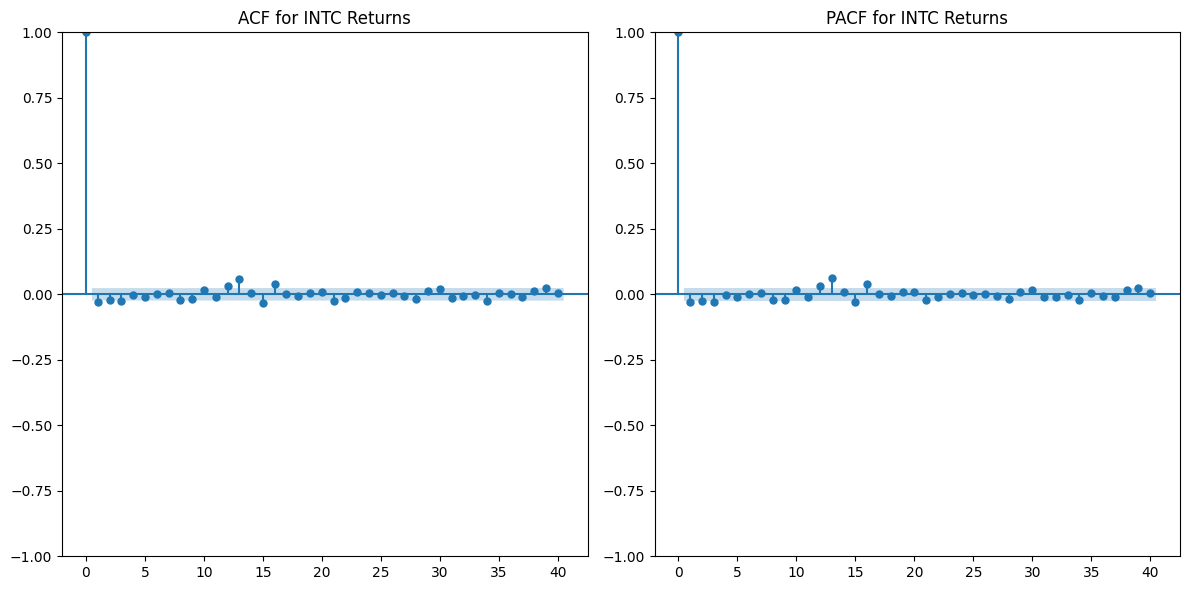

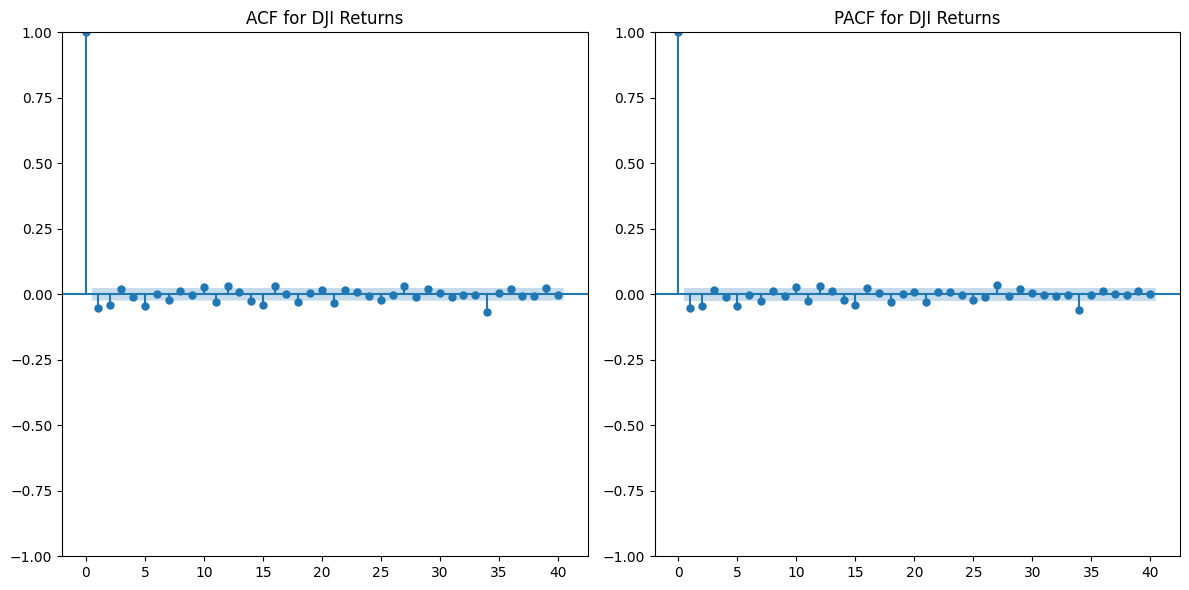

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Plot ACF and PACF for INTC returns
plt.figure(figsize=(12, 6))

# ACF plot for INTC returns
plt.subplot(121)
plot_acf(returns['INTC'], lags=40, ax=plt.gca())
plt.title('ACF for INTC Returns')

# PACF plot for INTC returns
plt.subplot(122)
plot_pacf(returns['INTC'], lags=40, ax=plt.gca())
plt.title('PACF for INTC Returns')

plt.tight_layout()
plt.show()

# Plot ACF and PACF for DJI returns
plt.figure(figsize=(12, 6))

# ACF plot for DJI returns
plt.subplot(121)
plot_acf(returns['DJI'], lags=40, ax=plt.gca())
plt.title('ACF for DJI Returns')

# PACF plot for DJI returns
plt.subplot(122)
plot_pacf(returns['DJI'], lags=40, ax=plt.gca())
plt.title('PACF for DJI Returns')

plt.tight_layout()
plt.show()

In [ ]:
shapiro_test_stock = shapiro(returns['INTC'])
shapiro_test_djia  = shapiro(returns['DJI'])

print("Shapiro-Wilk Test for INTC returns:")
print(f"Statistic: {shapiro_test_stock[0]}, p-value: {shapiro_test_stock[1]}")

print("\nShapiro-Wilk Test for DJI returns:")
print(f"Statistic: {shapiro_test_djia[0]}, p-value: {shapiro_test_djia[1]}")

Shapiro-Wilk Test for INTC returns:
Statistic: 0.9413824291065259, p-value: 1.0466783028348041e-45

Shapiro-Wilk Test for DJI returns:
Statistic: 0.9186589945363693, p-value: 3.176873947545072e-51


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6800.
  res = hypotest_fun_out(*samples, **kwds)


#Packages

In [ ]:
!sudo apt-get update
!sudo apt-get install libgmp3-dev
!sudo apt-get install libmpfr-dev

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,748 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,673 kB]
Fetched 11.8 MB in 3s (3,653 kB/s)
Reading package lists... Done
W: Skipping acqui

In [ ]:
%load_ext rpy2.ipython

In [ ]:
from rpy2.robjects.packages import importr   # import Python package
utils = importr('utils')    # Import R package

In [ ]:
#  R packages
packnames = ('MTS', 'rugarch', 'rmgarch', 'mgarchBEKK')  # Needs to be a list

# Set up
from rpy2.robjects.vectors import StrVector
utils = importr('utils')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list


names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))


In [ ]:
rmgarch = importr('rmgarch')
rugarch = importr('rugarch')
mgarchBEKK = importr('mgarchBEKK')
base = importr('base')
methods = importr('methods')
MTS = rpackages.importr('MTS')

In [ ]:
pandas2ri.activate()

In [ ]:
# Install required R packages
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
packnames = ('rmgarch', 'mgarchBEKK')
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if names_to_install:
    utils.install_packages(rpy2.robjects.vectors.StrVector(names_to_install))

# Import R packages
rmgarch = importr('rmgarch')
mgarchBEKK = importr('mgarchBEKK')

#DCC

In [ ]:
with localconverter(ro.default_converter + pandas2ri.converter):
    ro.globalenv['returns'] = ro.conversion.py2rpy(returns)

In [ ]:
r_code = """
library(rmgarch)

# Define the different GARCH specifications
spec_01 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(0,1)),
                      mean.model = list(armaOrder = c(0,0)),
                      distribution.model = "std")

spec_11 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
                      mean.model = list(armaOrder = c(0,0)),
                      distribution.model = "std")

spec_10 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1,0)),
                      mean.model = list(armaOrder = c(0,0)),
                      distribution.model = "std")

# Define the DCC specifications
dcc_spec_01 <- dccspec(uspec = multispec(replicate(2, spec_01)), dccOrder = c(1,1))
dcc_spec_11 <- dccspec(uspec = multispec(replicate(2, spec_11)), dccOrder = c(1,1))
dcc_spec_10 <- dccspec(uspec = multispec(replicate(2, spec_10)), dccOrder = c(1,1))

# Fit the DCC-GARCH models
dcc_fit_01 <- dccfit(dcc_spec_01, data = returns)
dcc_fit_11 <- dccfit(dcc_spec_11, data = returns)
dcc_fit_10 <- dccfit(dcc_spec_10, data = returns)

# Extract BIC values
bic_01 <- infocriteria(dcc_fit_01)[2]  # BIC for (0,1)
bic_11 <- infocriteria(dcc_fit_11)[2]  # BIC for (1,1)
bic_10 <- infocriteria(dcc_fit_10)[2]  # BIC for (1,0)

# Store BIC values in a data frame
bic_values <- data.frame(
    Model = c("(0,1)", "(1,1)", "(1,0)"),
    BIC = c(bic_01, bic_11, bic_10)
)

# Select the best model (lowest BIC)
best_model <- bic_values[which.min(bic_values$BIC), ]

# Print results
print(bic_values)
cat("Best model based on BIC: ", best_model$Model, "\n")

list(best_model = best_model)
 """
result = ro.r(r_code)


  Model      BIC
1 (0,1) 7.222976
2 (1,1) 6.513187
3 (1,0) 6.943017
Best model based on BIC:  (1,1) 


In [ ]:
ro.r('library(rmgarch)')

# Define univariate GARCH specification
ro.r('''
spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
                   mean.model = list(armaOrder = c(1,1)),
                   distribution.model = "ged")
''')

# Define DCC-GARCH specification
ro.r('''
dcc_spec <- dccspec(uspec = multispec(replicate(2, spec)), dccOrder = c(1,1))
''')

# Assign dcc_spec from R to Python
dcc_spec = ro.r('dcc_spec')

# Estimate DCC-GARCH model
dcc_fit = ro.r('dccfit')(dcc_spec, returns)

# Show the results
print(ro.r('show')(dcc_fit))


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  17
[VAR GARCH DCC UncQ] : [0+14+2+1]
No. Series           :  2
No. Obs.             :  6800
Log-Likelihood       :  -22069.35
Av.Log-Likelihood    :  -3.25 

Optimal Parameters
-----------------------------------
               Estimate  Std. Error   t value Pr(>|t|)
[DJI].mu       0.067381    0.006616   10.1845 0.000000
[DJI].ar1      0.881029    0.008398  104.9126 0.000000
[DJI].ma1     -0.904669    0.007178 -126.0316 0.000000
[DJI].omega    0.011952    0.002635    4.5354 0.000006
[DJI].alpha1   0.095663    0.011005    8.6926 0.000000
[DJI].beta1    0.895128    0.011368   78.7392 0.000000
[DJI].shape    1.351029    0.036586   36.9275 0.000000
[INTC].mu      0.074174    0.019047    3.8943 0.000098
[INTC].ar1     0.771778    0.005169  149.3049 0.000000
[INTC].ma1    -0.785734    0.005073 -15

#BEKK

In [ ]:
# Scale the returns properly to avoid numerical issues
scaler = StandardScaler()
scaled_returns = pd.DataFrame(scaler.fit_transform(returns), columns=returns.columns, index=returns.index)

In [ ]:
# Function to estimate BEKK model and select the best order
def model_order_selection(scaled_returns, max_order=3):
    best_aic = float('inf')
    best_bic = float('inf')
    best_p, best_q = None, None
    best_model = None

    for p in range(1, max_order + 1):
        for q in range(1, max_order + 2):
            try:
                # Fit BEKK model for each combination of p and q
                with localconverter(ro.default_converter + pandas2ri.converter):
                    r_returns = ro.conversion.py2rpy(scaled_returns)
                ro.globalenv['r_returns'] = r_returns

                r_code = f'''
                library(mgarchBEKK)
                r_returns <- r_returns + 1e-6 * diag(ncol(r_returns))  # Regularization
                bekk_fit <- BEKK(as.matrix(r_returns + diag(1e-6, nrow(r_returns))), order = c({p}, {q}), method = "Nelder-Mead")
                '''
                ro.r(r_code)
                bekk_fit = ro.r('bekk_fit')
                if bekk_fit is not None:
                    # Extract residuals correctly
                    residuals_r = ro.r('residuals(bekk_fit)')

                    # Convert residuals from R to Python while preserving column names
                    with localconverter(ro.default_converter + pandas2ri.converter):
                        residuals = ro.conversion.rpy2py(residuals_r)

                    # Convert residuals into a pandas DataFrame
                    residuals_df = pd.DataFrame(residuals_r).transpose()
                    residuals_df.columns = scaled_returns.columns
                    # Extract residuals for INTC and DJI from the DataFrame
                residuals_dji = residuals_df['DJI'].values
                residuals_intc = residuals_df['INTC'].values
                #  Calculate log-likelihood
                n_dji = len(residuals_dji)
                n_intc = len(residuals_intc)

                n = n_dji + n_intc  # total number of observations

                # Log-likelihood assuming normal distribution for both series
                log_likelihood_dji = -0.5*n_dji*np.log(2*np.pi) - 0.5*np.sum(np.square(residuals_dji))
                log_likelihood_intc = -0.5* n_intc * np.log(2*np.pi) - 0.5*np.sum(np.square(residuals_intc) )

                # Combine the log-likelihoods
                log_likelihood = log_likelihood_dji + log_likelihood_intc

                # Number of parameters
                k = p+q # Adjust based on model parameters

                # AIC and BIC for the combined model
                aic = -2*log_likelihood + 2*k
                bic = -2*log_likelihood + np.log(n)*k

                print(f"Fitted BEKK(p={p}, q={q}) - AIC: {aic}, BIC: {bic}")

                if aic < best_aic:
                    best_aic = aic
                    best_bic = bic
                    best_p, best_q = p, q
                    best_model = bekk_fit
                elif bic < best_bic:
                    best_bic = bic
                    best_p, best_q = p, q
                    best_model = bekk_fit

            except Exception as e:
                print(f"Error fitting BEKK(p={p}, q={q}): {e}")

    print(f"Best Model - BEKK(p={best_p}, q={best_q}) with AIC: {best_aic}, BIC: {best_bic}")
    return best_model

# Perform model order selection
best_bekk_model = model_order_selection(scaled_returns)

Fitted BEKK(p=1, q=1) - AIC: 37520.138365930616, BIC: 37535.17401607407
Fitted BEKK(p=1, q=2) - AIC: 38212.659843311354, BIC: 38235.21331852653
Fitted BEKK(p=1, q=3) - AIC: 37977.10055892581, BIC: 38007.17185921271
Fitted BEKK(p=1, q=4) - AIC: 38343.71773841965, BIC: 38381.30686377827
Fitted BEKK(p=2, q=1) - AIC: 37974.774541680075, BIC: 37997.32801689525
Fitted BEKK(p=2, q=2) - AIC: 37314.68230841651, BIC: 37344.7536087034
Fitted BEKK(p=2, q=3) - AIC: 37153.62524219572, BIC: 37191.21436755434
Fitted BEKK(p=2, q=4) - AIC: 37093.10810870728, BIC: 37138.21505913763
Fitted BEKK(p=3, q=1) - AIC: 37501.20386761967, BIC: 37531.27516790656
Fitted BEKK(p=3, q=2) - AIC: 37234.82882335001, BIC: 37272.41794870864
Fitted BEKK(p=3, q=3) - AIC: 37373.025168171036, BIC: 37418.13211860138
Fitted BEKK(p=3, q=4) - AIC: 37378.29943156331, BIC: 37430.92420706538
Best Model - BEKK(p=2, q=4) with AIC: 37093.10810870728, BIC: 37138.21505913763


In [ ]:
def estimate_bekk_model_default():
    global bekk_fit
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_returns = ro.conversion.py2rpy(scaled_returns)

    ro.globalenv['r_returns'] = r_returns

    # Define and estimate the BEKK model in R
    r_code = '''
    library(mgarchBEKK)

    # Small regularization term added to avoid singular matrices
    r_returns <- r_returns + 1e-6 * diag(ncol(r_returns))

    # Estimate the BEKK-GARCH model with robust optimization
    bekk_fit <- BEKK(as.matrix(r_returns + diag(1e-6, nrow(r_returns))), order = c(2, 4), method = "Nelder-Mead")

    '''
    ro.r(r_code)

    # reetrieve the estimated BEKK model
    bekk_fit = ro.r('bekk_fit')

    if bekk_fit is None:
        print("\nBEKK model estimation failed.")
        return None
    return bekk_fit

estimate_bekk_model_default()

if bekk_fit is not None:
    residuals_r = ro.r('residuals(bekk_fit)')

    with localconverter(ro.default_converter + pandas2ri.converter):
        residuals = ro.conversion.rpy2py(residuals_r)

    # convert residuals into a pandas DataFrame with proper column names
    residuals_df = pd.DataFrame(residuals_r).transpose()
    residuals_df.columns = scaled_returns.columns

    # Display residuals with column names
    print("\nResiduals from the BEKK model with column names:")
    print(residuals_df)

if isinstance(residuals_df, pd.DataFrame):
    # Extract residuals for INTC and DJI from the DataFrame
    residuals_dji = residuals_df['DJI'].values
    residuals_intc = residuals_df['INTC'].values

    # check lengths of residuals to verify
    print(f"DJI Residuals: {residuals_dji[:5]}")
    print(f"INTC Residuals: {residuals_intc[:5]}")
else:
    print("Residuals format is not as expected. Please check.")



n_dji = len(residuals_dji)
n_intc = len(residuals_intc)

# Combine the residuals to calculate for both stocks
n = n_dji + n_intc  # total number of observations (sum of both)

# Log-likelihood assuming normal distribution for both series
log_likelihood_dji = -0.5* n_dji*np.log(2*np.pi) - 0.5*np.sum(np.square(residuals_dji))
log_likelihood_intc = -0.5*n_intc * np.log(2*np.pi) - 0.5*np.sum(np.square(residuals_intc))

# Combine the log-likelihoods
log_likelihood = log_likelihood_dji + log_likelihood_intc

k = len(bekk_fit)

AIC = -2 * log_likelihood + 2 * k
BIC = -2 * log_likelihood + np.log(n) * k

print("\nModel Comparison (AIC/BIC for BEKK Model):")
print(f"Combined Log-Likelihood: {log_likelihood}")
print(f"Combined AIC: {AIC}")
print(f"Combined BIC: {BIC}")


Residuals from the BEKK model with column names:
Ticker       DJI      INTC
0       0.000000  0.000000
1       0.000000  0.000000
2       0.000000  0.000000
3       0.000000  0.000000
4      -0.095399  1.084484
...          ...       ...
6795   -2.054117  0.090104
6796    2.561468  0.156780
6797    0.656280 -0.312025
6798   -0.306086  0.400991
6799    0.538723 -0.299937

[6800 rows x 2 columns]
DJI Residuals: [ 0.          0.          0.          0.         -0.09539878]
INTC Residuals: [0.         0.         0.         0.         1.08448424]

Model Comparison (AIC/BIC for BEKK Model):
Combined Log-Likelihood: -18540.55405435364
Combined AIC: 37111.10810870728
Combined BIC: 37223.875484783144


In [ ]:
print(ro.r('bekk_fit$est.params'))


print(ro.r('bekk_fit$eigenvalues'))



$`1`
          [,1]       [,2]
[1,] 0.2995013 0.08060979
[2,] 0.0000000 0.61517309

$`2`
          [,1]      [,2]
[1,] 0.3648332 0.5064493
[2,] 0.1477634 0.1425685

$`3`
          [,1]       [,2]
[1,] 0.2724043 0.09356249
[2,] 0.1383847 0.29767508

$`4`
          [,1]       [,2]
[1,] 0.2956203 0.04362654
[2,] 0.1064575 0.40991245

$`5`
           [,1]       [,2]
[1,] 0.43848359 0.08348453
[2,] 0.02047093 0.11142313

$`6`
           [,1]       [,2]
[1,]  0.1649314 0.10658613
[2,] -0.3154801 0.06255909

$`7`
          [,1]      [,2]
[1,] 0.4445025 0.1441245
[2,] 0.2086076 0.2137991


[1.13337097 0.31791419 0.24942617 0.1960045 ]


In [ ]:
# Ljung-Box test
lb_dji = acorr_ljungbox(residuals_dji, lags=10)
lb_intc = acorr_ljungbox(residuals_intc, lags=10)

# Display p-values for Ljung-Box test (for lag=10)
print("Ljung-Box Test for DJI Residuals:", lb_dji)
print("Ljung-Box Test for INTC Residuals:", lb_intc)

# ARCH test (for checking remaining conditional heteroskedasticity)
arch_test_dji = arch_model(residuals_dji, vol='Garch', p=1, q=1).fit(disp="off")
arch_test_intc = arch_model(residuals_intc, vol='Garch', p=1, q=1).fit(disp="off")

print("ARCH Test for DJI Residuals:", arch_test_dji.summary())
print("ARCH Test for INTC Residuals:", arch_test_intc.summary())

Ljung-Box Test for DJI Residuals:       lb_stat  lb_pvalue
1    0.200727   0.654135
2    0.258530   0.878741
3    1.720752   0.632330
4    2.628914   0.621710
5    7.263169   0.201792
6    7.584099   0.270183
7    8.272693   0.309164
8    8.288462   0.405812
9    8.297037   0.504511
10  11.678626   0.307141
Ljung-Box Test for INTC Residuals:       lb_stat  lb_pvalue
1    2.279171   0.131122
2    2.287262   0.318660
3    5.674298   0.128577
4    6.114890   0.190731
5    6.130323   0.293744
6    6.461646   0.373508
7    6.756490   0.454667
8    8.743353   0.364407
9   10.780235   0.291074
10  10.955087   0.361028
ARCH Test for DJI Residuals:                      Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9049.87
Distribution:                  Norma

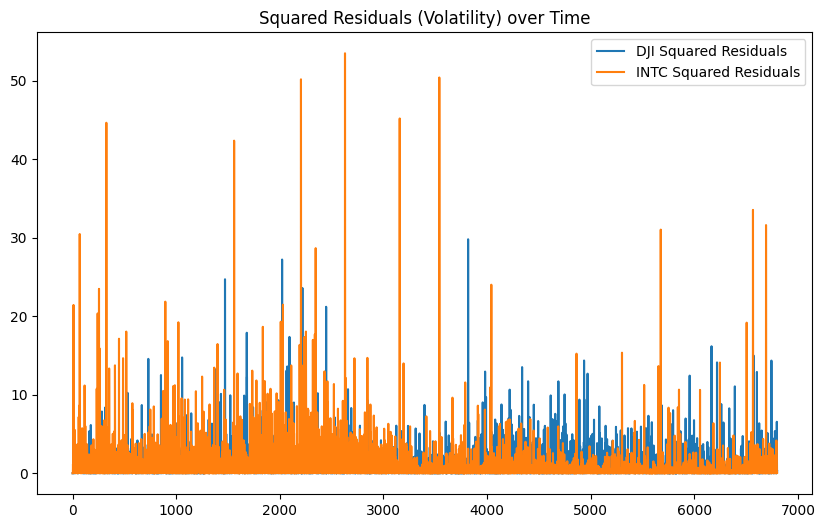

In [ ]:
# Plot the conditional variance (volatility) for DJI and INTC
plt.figure(figsize=(10, 6))
plt.plot(residuals_dji ** 2, label='DJI Squared Residuals')
plt.plot(residuals_intc ** 2, label='INTC Squared Residuals')
plt.legend()
plt.title('Squared Residuals (Volatility) over Time')
plt.show()



#Engel F-Test

In [ ]:
r_code = """
library(rmgarch)

# Define the GARCH specification
spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
                    mean.model = list(armaOrder = c(0,0)),
                    distribution.model = "ged")

# Define the DCC specification
dcc_spec <- dccspec(uspec = multispec(replicate(2, spec)), dccOrder = c(1,1))

# Fit the DCC model
dcc_fit <- dccfit(dcc_spec, data = returns)

# Extract residuals and conditional variance
dcc_resid <- residuals(dcc_fit)
dcc_cond_var <- fitted(dcc_fit)$h

# Compute squared residuals
dcc_squared_resid <- dcc_resid^2

# Ensure that dcc_squared_resid is properly converted to numeric if necessary
dcc_squared_resid <- as.numeric(dcc_squared_resid)

# Check the length and first few values
cat("Length of squared residuals:", length(dcc_squared_resid), "\n")
cat("First 5 squared residuals:\n")
print(head(dcc_squared_resid, 5))

# Perform the F-test for autocorrelation on squared residuals
# Ensure we have enough data for the lag and that the lengths match
if (length(dcc_squared_resid) >= 6) {
    # Create the lagged versions of squared residuals
    dcc_lags <- cbind(lag(dcc_squared_resid, 1),
                      lag(dcc_squared_resid, 2),
                      lag(dcc_squared_resid, 3),
                      lag(dcc_squared_resid, 4),
                      lag(dcc_squared_resid, 5))

    # Remove NA values from the lags and squared residuals (due to lagging)
    dcc_squared_resid_clean <- dcc_squared_resid[6:length(dcc_squared_resid)]
    dcc_lags_clean <- na.omit(dcc_lags)[6:length(dcc_squared_resid), ]

    # Run the regression model with lagged squared residuals
    model <- lm(dcc_squared_resid_clean ~ dcc_lags_clean)
    f_test <- summary(model)$fstatistic[1]  # Extract F-statistic value
} else {
    f_test <- NA  # If not enough data, return NA for F-test
}

# Return results to Python
list(dcc_resid = dcc_resid, dcc_cond_var = dcc_cond_var, f_test = f_test)
"""

result = ro.r(r_code)

dcc_resid = np.array(result[0])  # Residuals
dcc_cond_var = np.array(result[1])  # Conditional variances
f_test_value = result[2]  #  F-test result

print("F-test result from DCC-GARCH model:", f_test_value)
print("First 5 residuals:", dcc_resid[:5])
print(" conditional variances:", dcc_cond_var)

Length of squared residuals: 13600 
First 5 squared residuals:
[1] 0.718379295 0.011468308 0.006700592 0.008591242 0.011903088


F-test result from DCC-GARCH model: [8.92225907e+35]
First 5 residuals: [[ 0.84757259 -0.5724555 ]
 [-0.10709019 -1.58507313]
 [ 0.08185714  4.39358113]
 [-0.09268895  1.37206934]
 [ 0.10910127  2.2904975 ]]
 conditional variances: <rpy2.rinterface_lib.sexp.NULLType object at 0x7c24a0768ed0> [0]


In [ ]:
result_VaR_dcc = ro.r( """
library(rmgarch)

# Define the GARCH specification with Student-t distribution
spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
                   mean.model = list(armaOrder = c(0,0)),
                   distribution.model = "std")  # Student-t distribution

# Define the DCC-GARCH specification
dcc_spec <- dccspec(uspec = multispec(replicate(2, spec)), dccOrder = c(1,1))

# Fit the DCC-GARCH model
dcc_fit <- dccfit(dcc_spec, data = returns)

# Extract estimated conditional covariance matrices
dcc_cov_mat <- rcov(dcc_fit)

# Define portfolio weights
w <- 0.5

# Compute one-day-ahead 99% VaR
VaR_99 <- rep(NA, length(dcc_cov_mat))

for (t in 1:length(dcc_cov_mat)) {
    Ht <- matrix(dcc_cov_mat[[t]], nrow=2, ncol=2)
    VaR_99[t] <- 1.65 * sqrt(w^2 * Ht[1,1] + (1-w)^2 * Ht[2,2] + 2*w*(1-w) * Ht[1,2])
}

# Debugging: Check number of NA values
cat("Number of NA values in VaR_99:", sum(is.na(VaR_99)), "\n")

# Compute portfolio returns
portfolio_returns <- w * returns[,1] + (1 - w) * returns[,2]

# Ensure alignment of VaR_99 and portfolio_returns
if (length(portfolio_returns) >= length(VaR_99)) {
    portfolio_returns <- tail(portfolio_returns, length(VaR_99))
} else {
    VaR_99 <- tail(VaR_99, length(portfolio_returns))
}

# Compute hit variable
hit <- as.numeric(portfolio_returns < -VaR_99) - 0.05

# Debugging: Check first 5 hit values
cat("First 5 hit values:\n", head(hit, 5), "\n")

# Plot histogram of portfolio returns
hist(portfolio_returns, main="Histogram of Portfolio Returns", breaks=50)

# Count VaR exceedances
num_exceedances <- sum(portfolio_returns < -VaR_99)
cat("Number of VaR exceedances:", num_exceedances, "\n")

# Perform Dynamic Quantile Test (DQT)
if (length(hit) > 6) {
    hit_lags <- cbind(lag(hit, 1), lag(hit, 2), lag(hit, 3), lag(hit, 4), lag(hit, 5))

    # Remove NA values from hit and its lags
    hit_clean <- na.omit(hit[6:length(hit)])
    hit_lags_clean <- na.omit(hit_lags)[6:length(hit), ]

    # Fit DQT regression model
    dq_model <- lm(hit_clean ~ hit_lags_clean + VaR_99[6:length(hit)])
    dq_f_test <- summary(dq_model)$fstatistic[1]  # Extract F-statistic
} else {
    dq_f_test <- NA
}

# Print DQT results
cat("Dynamic Quantile Test F-statistic:", dq_f_test, "\n")

# Return results to Python
list(VaR_99 = VaR_99, hit = hit, dq_f_test = dq_f_test)
"""
)


VaR_DCC = np.array(result_VaR_dcc[0])  # 99% VaR values
hit_values = np.array(result_VaR_dcc[1])  # Hit function values
dq_f_test_value = result_VaR_dcc[2]  # F-test result for Dynamic Quantile Test


print("Dynamic Quantile Test F-statistic:", dq_f_test_value)
print("hit values:", hit_values)


Number of NA values in VaR_99: 0 
First 5 hit values:
 -0.05 -0.05 -0.05 -0.05 -0.05 
Number of VaR exceedances: 885 
Dynamic Quantile Test F-statistic: 3.752281e+33 


Dynamic Quantile Test F-statistic: [3.7522814e+33]
hit values: [-0.05 -0.05 -0.05 ... -0.05 -0.05 -0.05]


In [ ]:
# Number of hits
np.sum(hit_values>0 )

885

In [ ]:
# hitting ratio
np.sum(hit_values>0)/len(hit_values)

0.13014705882352942

In [ ]:
returns["VaR_DCC"]=VaR_DCC

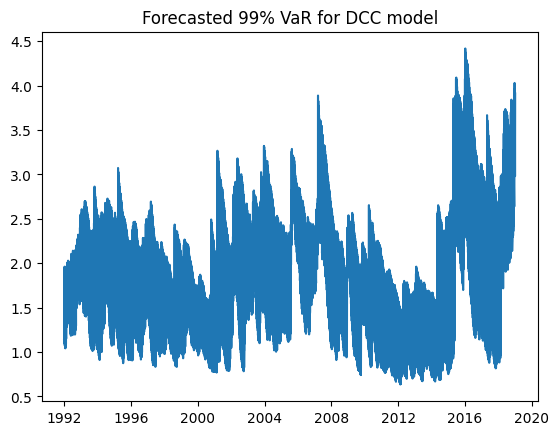

In [ ]:
plt.title("Forecasted 99% VaR for DCC model")
plt.plot(returns["VaR_DCC"])


BEKK VaR

In [ ]:
with localconverter(ro.default_converter + pandas2ri.converter):
    ro.globalenv['bekk_fit'] = ro.conversion.py2rpy(bekk_fit)


In [ ]:
r_code = """
# Extract residuals from BEKK model
bekk_resid <- bekk_fit$eps  # Extract residuals directly if they exist

# Check if residuals exist
if (is.null(bekk_resid)) {
    stop("Residuals are NULL. Check the BEKK model output.")
}

# Convert residuals to matrix form
bekk_resid_matrix <- as.matrix(bekk_resid)

# Compute squared residuals
bekk_squared_resid <- bekk_resid_matrix^2

# Ensure numeric conversion
bekk_squared_resid <- as.numeric(bekk_squared_resid)

# Perform F-test only if we have enough data
if (length(bekk_squared_resid) >= 6) {
    bekk_lags <- cbind(lag(bekk_squared_resid, 1),
                       lag(bekk_squared_resid, 2),
                       lag(bekk_squared_resid, 3),
                       lag(bekk_squared_resid, 4),
                       lag(bekk_squared_resid, 5))

    bekk_squared_resid_clean <- bekk_squared_resid[6:length(bekk_squared_resid)]
    bekk_lags_clean <- na.omit(bekk_lags)[6:length(bekk_squared_resid), ]

    model <- lm(bekk_squared_resid_clean ~ bekk_lags_clean)
    f_test <- summary(model)$fstatistic[1]
} else {
    f_test <- NA
}

# Return results to Python
list(bekk_resid = bekk_resid_matrix, f_test = f_test)
"""

result = ro.r(r_code)

bekk_resid = np.array(result[0])  # Residuals
f_test_value = result[1]  # F-test result

print("F-test result from BEKK-GARCH model:", f_test_value)
print("First 5 residuals:", bekk_resid[:5])

F-test result from BEKK-GARCH model: [3.12342526e+35]
First 5 residuals: [[ 0.82924099 -0.2338892 ]
 [-0.06715499 -0.6605512 ]
 [ 0.11025975  1.85852761]
 [-0.05363175  0.58542784]
 [ 0.13584201  0.97240352]]


In [ ]:
r_code = """
# Extract estimated conditional covariance matrices from BEKK model
bekk_cov_matrices <- bekk_fit$H  # Correct way to extract H matrices

# Check the structure of the BEKK covariance matrices
cat("Class of BEKK covariance matrices:", class(bekk_cov_matrices), "\n")
cat("Length of BEKK covariance matrices:", length(bekk_cov_matrices), "\n")
cat("First few elements of BEKK covariance matrices:\n")
print(head(bekk_cov_matrices))

# Define portfolio weights
w <- 0.5

# Compute one-day-ahead 99% VaR
VaR_99 <- rep(NA, length(bekk_cov_matrices))

# If BEKK covariance matrices are a list of matrices, we need to adjust the extraction
for (t in 1:length(bekk_cov_matrices)) {
    Ht <- bekk_cov_matrices[[t]]      
    VaR_99[t] <- 1.65 * sqrt(w^2 * Ht[1,1] + (1-w)^2 * Ht[2,2] + 2*w*(1-w) * Ht[1,2])
}

# Debugging: Check number of NA values
cat("Number of NA values in VaR_99:", sum(is.na(VaR_99)), "\n")

# Compute portfolio returns
portfolio_returns <- w * returns[,1] + (1 - w) * returns[,2]

# Ensure alignment of VaR_99 and portfolio_returns
if (length(portfolio_returns) >= length(VaR_99)) {
    portfolio_returns <- tail(portfolio_returns, length(VaR_99))
} else {
    VaR_99 <- tail(VaR_99, length(portfolio_returns))
}

# Compute hit variable
hit <- as.numeric(portfolio_returns < -VaR_99) - 0.05

# Debugging: Check first 5 hit values
cat("First 5 hit values:\n", head(hit, 5), "\n")

# Plot histogram of portfolio returns
hist(portfolio_returns, main="Histogram of Portfolio Returns (BEKK)", breaks=50)

# Count VaR exceedances
num_exceedances <- sum(portfolio_returns < -VaR_99)
cat("Number of VaR exceedances:", num_exceedances, "\n")

# Perform Dynamic Quantile Test (DQT)
if (length(hit) > 6) {
    hit_lags <- cbind(lag(hit, 1), lag(hit, 2), lag(hit, 3), lag(hit, 4), lag(hit, 5))

    # Remove NA values from hit and its lags
    hit_clean <- na.omit(hit[6:length(hit)])
    hit_lags_clean <- na.omit(hit_lags)[6:length(hit), ]

    # Fit DQT regression model
    dq_model <- lm(hit_clean ~ hit_lags_clean + VaR_99[6:length(hit)])
    dq_f_test <- summary(dq_model)$fstatistic[1]  # Extract F-statistic
} else {
    dq_f_test <- NA
}

# Print DQT results
cat("Dynamic Quantile Test F-statistic (BEKK):", dq_f_test, "\n")

# Return results to Python
list(VaR_99 = VaR_99, hit = hit, dq_f_test = dq_f_test)
"""

result_VaR_bekk = ro.r(r_code)

VaR_BEKK = np.array(result_VaR_bekk[0])  # 99% VaR values
hit_values_BEKK = np.array(result_VaR_bekk[1])  # Hit function values
dq_f_test_value_BEKK = result_VaR_bekk[2]  # F-test result for Dynamic Quantile Test

print("Dynamic Quantile Test F-statistic (BEKK):", dq_f_test_value_BEKK)
print("Hit values (BEKK):", hit_values_BEKK)

Class of BEKK covariance matrices: list 
Length of BEKK covariance matrices: 6800 
First few elements of BEKK covariance matrices:
[[1]]
           DJI      INTC
DJI  1.0001471 0.5629588
INTC 0.5629588 1.0001471

[[2]]
           DJI      INTC
DJI  1.0001471 0.5629588
INTC 0.5629588 1.0001471

[[3]]
           DJI      INTC
DJI  1.0001471 0.5629588
INTC 0.5629588 1.0001471

[[4]]
           DJI      INTC
DJI  1.0001471 0.5629588
INTC 0.5629588 1.0001471

[[5]]
          [,1]      [,2]
[1,] 0.6228285 0.3233345
[2,] 0.3233345 0.8717383

[[6]]
          [,1]      [,2]
[1,] 0.6020017 0.4208564
[2,] 0.4208564 1.1666102

Number of NA values in VaR_99: 0 
First 5 hit values:
 -0.05 -0.05 -0.05 -0.05 -0.05 
Number of VaR exceedances: 878 
Dynamic Quantile Test F-statistic (BEKK): 8.23677e+32 
Dynamic Quantile Test F-statistic (BEKK): [8.23676985e+32]
Hit values (BEKK): [-0.05 -0.05 -0.05 ... -0.05 -0.05 -0.05]


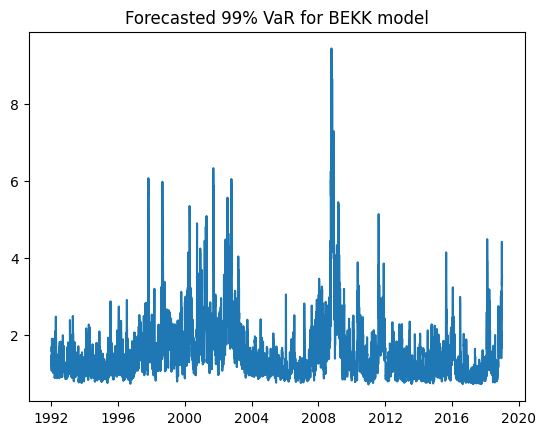

In [ ]:
plt.title("Forecasted 99% VaR for BEKK model")
returns["VaR_BEKK"]=VaR_BEKK
plt.plot(returns["VaR_BEKK"])

In [ ]:
# Number of hits
np.sum(hit_values_BEKK >0 )

878

In [ ]:
# hitting ratio
np.sum(hit_values_BEKK >0 )/len(hit_values_BEKK)

0.12911764705882353